In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install unrar
# !unrar x "/content/drive/MyDrive/Mask Dataset/dataset.rar"

In [3]:
# importing libraries
 
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import glob
import os
import cv2
import seaborn as sns
import random as rand
from sklearn.utils import shuffle

In [4]:
# Defining path to subdirectories in dataset

mask_path = "/content/dataset/with_mask"
no_mask_path = "/content/dataset/without_mask"

In [5]:
# Creating a dataframe containing labels and image paths

image_mask = []
target_mask = []
for i in os.listdir(mask_path):
    pic = os.path.join(mask_path + "/", i)
    image_mask.append(pic)
    target_mask.append("mask")   

image_no_mask = []
target_no_mask = []
for i in os.listdir(no_mask_path):
    pic = os.path.join(no_mask_path + "/", i)
    image_no_mask.append(pic)
    target_no_mask.append("without_mask")

mask = pd.DataFrame()
mask["image"] = image_mask
mask["target"] = target_mask

no_mask = pd.DataFrame()
no_mask["image"] = image_no_mask
no_mask["target"] = target_no_mask

data = pd.concat([mask, no_mask], axis = 0, ignore_index = True)
data = shuffle(data)
data

,image,target
4911,/content/dataset/without_mask/720 without_mask...,without_mask
1339,/content/dataset/with_mask/1721with_mask.jpg,mask
4746,/content/dataset/without_mask/2397 without_mas...,without_mask
305,/content/dataset/with_mask/1641with_mask.jpg,mask
2747,/content/dataset/with_mask/979with_mask.jpg,mask
...,...,...
1797,/content/dataset/with_mask/2346with_mask.jpg,mask
4241,/content/dataset/without_mask/1804 without_mas...,without_mask
1277,/content/dataset/with_mask/1260with_mask.jpg,mask
2061,/content/dataset/with_mask/1330with_mask.jpg,mask


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


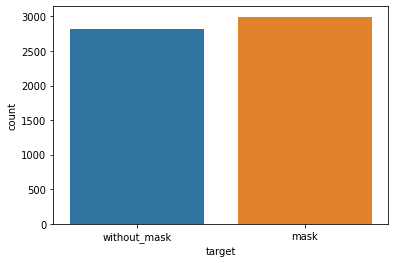

In [6]:
# Plot to check dataset balance

sns.countplot(data["target"])

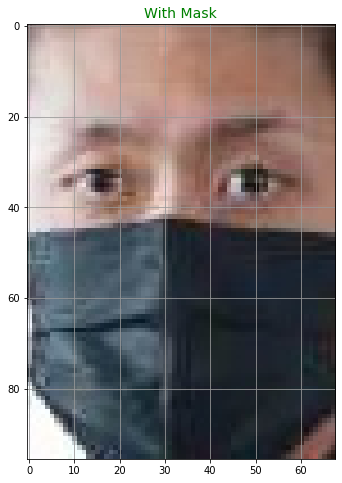

In [7]:
# Image with mask

plt.figure(figsize=(12,8))

img = load_img(mask["image"][8])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

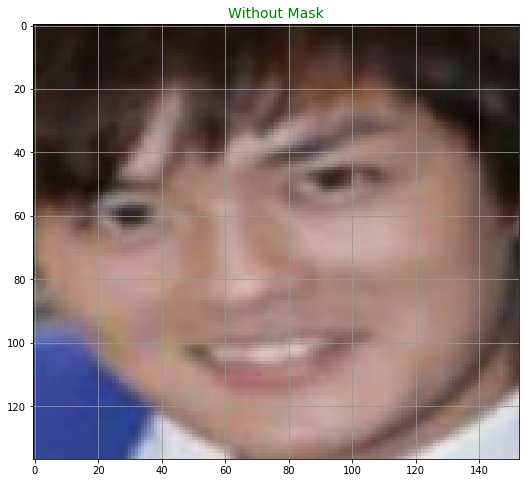

In [8]:
# Image without mask

plt.figure(figsize=(12,8))

img = load_img(no_mask["image"][750])
plt.imshow(img)
plt.title("Without Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

In [9]:
# making train, validation and test split

train, val, test = np.split(data.sample(frac=1, random_state=42), [int(.6*len(data)), int(.8*len(data))])

In [10]:
train["target"].value_counts() #checking the variation of the labels

mask            1790
without_mask    1701
Name: target, dtype: int64

In [11]:
val["target"].value_counts() #checking the variation of the labels

without_mask    586
mask            578
Name: target, dtype: int64

In [12]:
test["target"].value_counts() #checking the variation of the labels

mask            627
without_mask    537
Name: target, dtype: int64

In [13]:
# making generators for train, validation and test data

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col = "image",
                                                    y_col = "target",
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = "binary")

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe = val,
                                                x_col = "image",
                                                y_col = "target",
                                                target_size = (150, 150),
                                                batch_size = 32,
                                                class_mode = "binary")


test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  x_col = "image",
                                                  y_col = "target",
                                                  target_size = (150, 150),
                                                  class_mode = "binary",
                                                  batch_size = 32)

Found 3491 validated image filenames belonging to 2 classes.
Found 1164 validated image filenames belonging to 2 classes.
Found 1164 validated image filenames belonging to 2 classes.


In [14]:
# using VGG19 architecture and its wieghts to train

from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
# Compiling the model

model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.Adam(lr = 1e-4),
             metrics = ["acc"])  

In [16]:
# Storing the model with least validation loss using callbacks
 
filepath = '/content/callbacks'
callback = callbacks.ModelCheckpoint(filepath=filepath,monitor='val_loss',
                                     mode='min',save_best_only=True)

In [17]:
# training the model on 50 epochs

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps=len(val_generator)//32,
                    callbacks=[callback])

Epoch 1/50
3/3 [==============================] - 9s 879ms/step - loss: 0.6653 - acc: 0.5846 - val_loss: 0.6513 - val_acc: 0.5938
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 2/50
3/3 [==============================] - 2s 604ms/step - loss: 0.6197 - acc: 0.7096 - val_loss: 0.6781 - val_acc: 0.5000
Epoch 3/50
3/3 [==============================] - 2s 630ms/step - loss: 0.6442 - acc: 0.6406 - val_loss: 0.5847 - val_acc: 0.7812
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 2s 587ms/step - loss: 0.6502 - acc: 0.6562 - val_loss: 0.6056 - val_acc: 0.7500
Epoch 5/50
3/3 [==============================] - 2s 598ms/step - loss: 0.5978 - acc: 0.7578 - val_loss: 0.5464 - val_acc: 0.7812
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 6/50
3/3 [==============================] - 1s 515ms/step - loss: 0.6468 - acc: 0.6602 - val_loss: 0.5772 - val_acc: 0.7812
Epoch 7/50
3/3 [==============================] - 2s 572ms/step - loss: 0.6115 - acc: 0.7305 - val_loss: 0.5577 - val_acc: 0.8750
Epoch 8/50
3/3 [==============================] - 1s 491ms/step - loss: 0.6147 - acc: 0.6589 - val_loss: 0.5378 - val_acc: 0.8125
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 9/50
3/3 [==============================] - 2s 649ms/step - loss: 0.6086 - acc: 0.6641 - val_loss: 0.5971 - val_acc: 0.6875
Epoch 10/50
3/3 [==============================] - 2s 683ms/step - loss: 0.5692 - acc: 0.8008 - val_loss: 0.4

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 2s 576ms/step - loss: 0.5483 - acc: 0.8568 - val_loss: 0.4929 - val_acc: 0.8750
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 12/50
3/3 [==============================] - 1s 504ms/step - loss: 0.5559 - acc: 0.8281 - val_loss: 0.5184 - val_acc: 0.8438
Epoch 13/50
3/3 [==============================] - 2s 665ms/step - loss: 0.5717 - acc: 0.8125 - val_loss: 0.4711 - val_acc: 0.8750
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 14/50
3/3 [==============================] - 2s 759ms/step - loss: 0.5920 - acc: 0.7669 - val_loss: 0.5154 - val_acc: 0.7812
Epoch 15/50
3/3 [==============================] - 2s 754ms/step - loss: 0.5746 - acc: 0.7930 - val_loss: 0.4989 - val_acc: 0.8438
Epoch 16/50
3/3 [==============================] - 2s 570ms/step - loss: 0.5242 - acc: 0.7708 - val_loss: 0.4889 - val_acc: 0.9062
Epoch 17/50
3/3 [==============================] - 2s 513ms/step - loss: 0.5287 - acc: 0.8503 - val_loss

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 2s 708ms/step - loss: 0.4824 - acc: 0.8607 - val_loss: 0.4468 - val_acc: 0.9062
Epoch 24/50
3/3 [==============================] - 2s 554ms/step - loss: 0.4771 - acc: 0.8763 - val_loss: 0.3970 - val_acc: 0.9375
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 25/50
3/3 [==============================] - 2s 567ms/step - loss: 0.4758 - acc: 0.8568 - val_loss: 0.4032 - val_acc: 0.9688
Epoch 26/50
3/3 [==============================] - 2s 568ms/step - loss: 0.4605 - acc: 0.9349 - val_loss: 0.4094 - val_acc: 0.9062
Epoch 27/50
3/3 [==============================] - 2s 617ms/step - loss: 0.4550 - acc: 0.8984 - val_loss: 0.3669 - val_acc: 0.9688
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 28/50
3/3 [==============================] - 2s 662ms/step - loss: 0.4252 - acc: 0.8997 - val_loss: 0.3156 - val_acc: 0.9688
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 29/50
3/3 [==========================

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 2s 548ms/step - loss: 0.4606 - acc: 0.8385 - val_loss: 0.2862 - val_acc: 0.9688
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 41/50
3/3 [==============================] - 2s 679ms/step - loss: 0.4219 - acc: 0.8776 - val_loss: 0.3701 - val_acc: 0.9062
Epoch 42/50
3/3 [==============================] - 1s 529ms/step - loss: 0.3946 - acc: 0.8841 - val_loss: 0.3021 - val_acc: 0.9375
Epoch 43/50
3/3 [==============================] - 1s 510ms/step - loss: 0.4369 - acc: 0.8737 - val_loss: 0.3665 - val_acc: 0.9375
Epoch 44/50
2/3 [===================>..........] - ETA: 0s - loss: 0.4110 - acc: 0.8359

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 1s 499ms/step - loss: 0.4078 - acc: 0.8503 - val_loss: 0.2989 - val_acc: 0.9688
Epoch 45/50
3/3 [==============================] - 1s 511ms/step - loss: 0.3942 - acc: 0.9232 - val_loss: 0.2670 - val_acc: 0.9688
INFO:tensorflow:Assets written to: /content/callbacks/assets
Epoch 46/50
3/3 [==============================] - 2s 546ms/step - loss: 0.4201 - acc: 0.8477 - val_loss: 0.3621 - val_acc: 0.8438
Epoch 47/50
3/3 [==============================] - 2s 730ms/step - loss: 0.3656 - acc: 0.9043 - val_loss: 0.3765 - val_acc: 0.8750
Epoch 48/50
3/3 [==============================] - 2s 609ms/step - loss: 0.4074 - acc: 0.9049 - val_loss: 0.3158 - val_acc: 0.8750
Epoch 49/50
3/3 [==============================] - 2s 634ms/step - loss: 0.4212 - acc: 0.8971 - val_loss: 0.2934 - val_acc: 1.0000
Epoch 50/50
3/3 [==============================] - 2s 781ms/step - loss: 0.3780 - acc: 0.8945 - val_loss: 0.2935 - val_acc: 0.9688


In [19]:
# saving the model

tensorflow.keras.models.save_model(model, '/content/callbacks/model.h5')


In [20]:
# loading the saved model

mask_model = tensorflow.keras.models.load_model('/content/callbacks/model.h5')

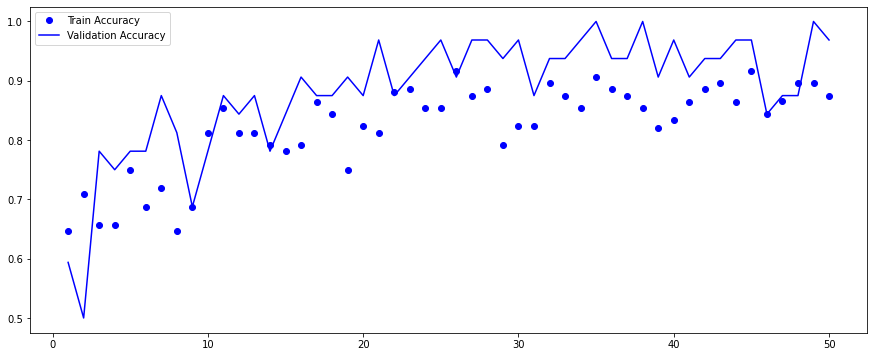

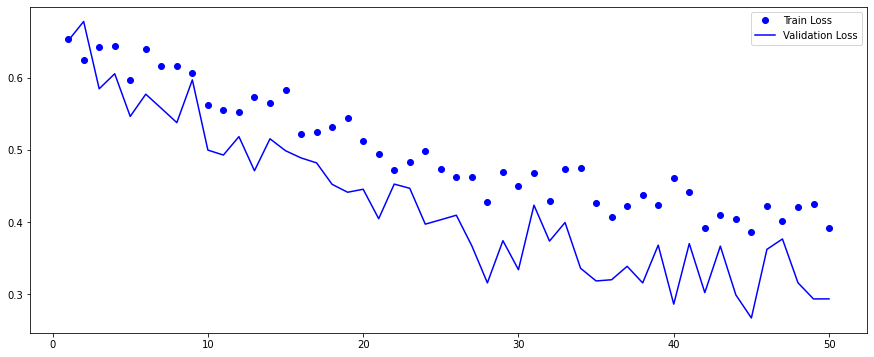

In [21]:
# visualising the losses

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (15, 6))

plt.plot(epochs, acc, "bo", label = "Train Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.legend()

plt.figure(figsize = (15, 6))

plt.plot(epochs, loss, "bo", label = "Train Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.legend()

plt.show()

In [22]:
# testing the model

test_loss, test_acc = mask_model.evaluate(test_generator, steps = 9)
print("Test ACC: ", round(test_acc, 2))

9/9 [==============================] - 2s 176ms/step - loss: 0.3308 - acc: 0.9062
Test ACC:  0.91


In [ ]:
# Test accuracy comes out to be 90%

In [23]:
prediction = mask_model.predict(test_generator)
prediction

array([[0.47965962],
       [0.5158796 ],
       [0.77233845],
       ...,
       [0.65709656],
       [0.70723885],
       [0.7008933 ]], dtype=float32)

In [24]:
classes = []

for x in prediction:
  if x > 0.5:
    classes.append(1)
  else:
    classes.append(0)

In [25]:
sum(classes)

513

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


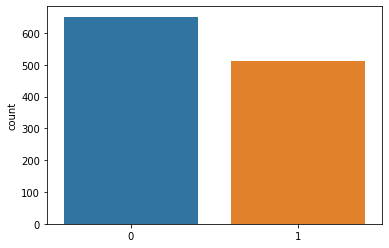

In [27]:
sns.countplot(classes)

Checking model on new images

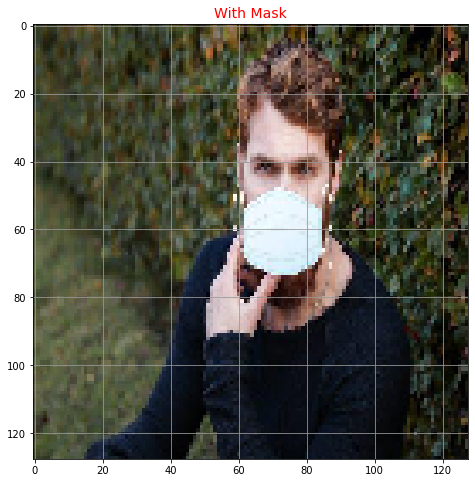

In [28]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/content/dataset/with_mask/0with_mask.jpg', target_size=(128, 128))
img = test_image
test_image = image.img_to_array(test_image)

test_image = test_image.reshape(128, 128, 3)
test_image = np.expand_dims(test_image, axis=0)

#test_image.shape
result = mask_model.predict(test_image, batch_size=1)

if result[0][0] < 0.5:
  # with mask
  plt.figure(figsize=(12,8))

  plt.imshow(img)
  plt.title("With Mask", color = "red", size = 14)
  plt.grid(color='#999999', linestyle='-')
  plt.show()

if result[0][0] > 0.5:
  # without mask

  plt.figure(figsize=(12,8))
  plt.imshow(img)
  plt.title("Without Mask", color = "red", size = 14)
  plt.grid(color='#999999', linestyle='-')
  plt.show()

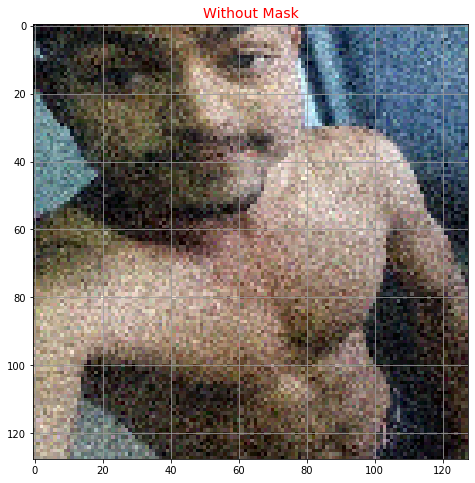

In [30]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/content/dataset/without_mask/1282 without_mask.jpg', target_size=(128, 128))
img = test_image
test_image = image.img_to_array(test_image)

test_image = test_image.reshape(128, 128, 3)
test_image = np.expand_dims(test_image, axis=0)

#test_image.shape
result = mask_model.predict(test_image, batch_size=1)

if result[0][0] < 0.5:
  # with mask
  plt.figure(figsize=(12,8))

  plt.imshow(img)
  plt.title("With Mask", color = "red", size = 14)
  plt.grid(color='#999999', linestyle='-')
  plt.show()

if result[0][0] > 0.5:
  # without mask

  plt.figure(figsize=(12,8))
  plt.imshow(img)
  plt.title("Without Mask", color = "red", size = 14)
  plt.grid(color='#999999', linestyle='-')
  plt.show()

In [ ]:
# Thank you for Watching...